**《深度学习之 PyTorch 实战》**

讲师作者：[土豆老师](https://iphysresearch.github.io)

# 计算机视觉

近年来，深度学习一直是提高计算机视觉系统性能的变革力量。 无论是医疗诊断、自动驾驶车辆，还是智能滤镜、摄像头监控，许多计算机视觉领域的应用都与我们当前和未来的生活密切相关。 可以说，最先进的计算机视觉应用程序与深度学习几乎是不可分割的。 有鉴于此，本讲将重点介绍计算机视觉领域，并探讨最近在学术界和行业中具有影响力的方法和应用。


## 目标检测数据集（香蕉）

>(Restart your kernel here)

目标检测领域没有像 MNIST 和 Fashion-MNIST 那样的小数据集。 为了快速测试目标检测模型，我们收集并标记了一个小型数据集。 首先，我们拍摄了一组香蕉的照片，并生成了 1000 张不同角度和大小的香蕉图像。 然后，我们在一些背景图片的随机位置上放一张香蕉的图像。 最后，我们在图片上为这些香蕉标记了边界框。




### 下载数据集

包含所有图像和 csv 标签文件的香蕉检测数据集可以直接从互联网下载。



In [18]:
%matplotlib inline                 
import os
import pandas as pd
import torch
import torchvision
import dl4wm

dl4wm.DATA_HUB['banana-detection'] = (
    dl4wm.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [19]:
torchvision.__version__

'0.11.3'

### 读取数据集

通过 `read_data_bananas` 函数，我们读取香蕉检测数据集。 该数据集包括一个的 csv 文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。

In [20]:
# 以保存至 dl4wm 程序包中
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签。"""
    data_dir = dl4wm.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image(
                os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

通过使用 `read_data_bananas` 函数读取图像和标签，以下 `BananasDataset` 类别将允许我们创建一个自定义 `Dataset` 实例来加载香蕉检测数据集。

In [21]:
# 以保存至 dl4wm 程序包中
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集。"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

最后，我们定义 `load_data_bananas` 函数，来为训练集和测试集返回两个数据加载器实例。对于测试集，无需按随机顺序读取它。

In [22]:
# 以保存至 dl4wm 程序包中
def load_data_bananas(batch_size):
    """加载香蕉检测数据集。"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

让我们读取一个小批量，并打印其中的图像和标签的形状。 图像的小批量的形状为（批量大小、通道数、高度、宽度），看起来很眼熟：它与我们之前图像分类任务中的相同。 标签的小批量的形状为（批量大小， 𝑚 ，5），其中  𝑚  是数据集的任何图像中边界框可能出现的最大数量。

小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。 通常来说，图像可能拥有不同数量个边界框；因此，在达到  𝑚  之前，边界框少于  𝑚  的图像将被非法边界框填充。 这样，每个边界框的标签将被长度为 5 的数组表示。 数组中的第一个元素是边界框中对象的类别，其中 -1 表示用于填充的非法边界框。 数组的其余四个元素是边界框左上角和右下角的 ( 𝑥 ,  𝑦 ) 坐标值（值域在0到1之间）。 对于香蕉数据集而言，由于每张图像上只有一个边界框，因此  𝑚=1 。

In [23]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

# Downloading ./Datasets/banana-detection.zip from http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip...

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

### 示范

让我们展示 10 幅带有真实边界框的图像。 我们可以看到在所有这些图像中香蕉的旋转角度、大小和位置都有所不同。 当然，这只是一个简单的人工数据集，实践中真实世界的数据集通常要复杂得多。

AttributeError: 'numpy.ndarray' object has no attribute 'add_patch'

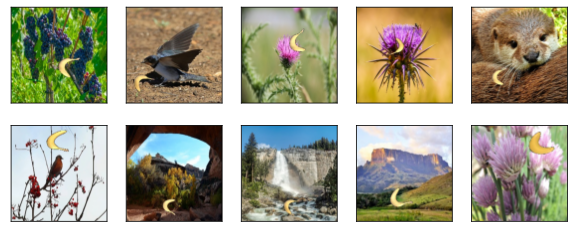

In [24]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = dl4wm.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    dl4wm.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

### 小结

- 我们收集的香蕉检测数据集可用于演示目标检测模型。

- 用于目标检测的数据加载与图像分类的数据加载类似。但是，在目标检测中，标签还包含真实边界框的信息，它不出现在图像分类中。

## 单发多框检测（SSD）

>(Restart your kernel here)


在上一讲中，我们分别介绍了边界框、锚框、多尺度目标检测和用于目标检测的数据集。 现在我们已经准备好使用这样的背景知识来设计一个目标检测模型：单发多框检测（SSD）。 该模型简单、快速且被广泛使用。尽管这只是大量目标检测模型中的一个，但本节中的一些设计原则和实现细节也适用于其他模型。

### 模型

下图描述了单发多框检测模型的设计。 此模型主要由基础网络组成，其后是几个多尺度特征块。 基本网络用于从输入图像中提取特征，因此它可以使用深度卷积神经网络。 单发多框检测论文中选用了在分类层之前截断的 VGG ，现在也常用 ResNet 替代。 我们可以设计基础网络，使它输出的高和宽较大。 这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。 接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。

回想一下在「多尺度目标检测」节 中，通过深度神经网络分层表示图像的多尺度目标检测的设计。 由于接近下图顶部的多尺度特征图较小，但具有较大的感受野，它们适合检测较少但较大的物体。 简而言之，通过多尺度特征块，单发多框检测生成不同大小的锚框，并通过预测边界框的类别和偏移量来检测大小不同的目标，因此这是一个多尺度目标检测模型。

![](https://i.loli.net/2021/07/11/gnH6tzl9JipYyrk.png)


在下面，我们将介绍上图中不同块的实施细节。 首先，我们将讨论如何实施类别和边界框预测。


#### 类别预测层

设目标类别的数量为  𝑞 。这样一来，锚框有  𝑞+1  个类别，其中 0 类是背景。 在某个尺度下，设特征图的高和宽分别为  ℎ  和  𝑤 。 如果以其中每个单元为中心生成  𝑎  个锚框，那么我们需要对  ℎ𝑤𝑎  个锚框进行分类。 如果使用全连接层作为输出，很容易导致模型参数过多。 回忆「网络中的网络」节介绍的使用卷积层的通道来输出类别预测的方法， 单发多框检测采用同样的方法来降低模型复杂度。

具体来说，类别预测层使用一个保持输入高和宽的卷积层。 这样一来，输出和输入在特征图宽和高上的空间坐标一一对应。 考虑输出和输入同一空间坐标（ 𝑥 、 𝑦 ）：输出特征图上（ 𝑥 、 𝑦 ）坐标的通道里包含了以输入特征图 （ 𝑥 、 𝑦 ）坐标为中心生成的所有锚框的类别预测。 因此输出通道数为  𝑎(𝑞+1)  ，其中索引为  𝑖(𝑞+1)+𝑗  （ 0≤𝑗≤𝑞 ）的通道代表了索引为  𝑖  的锚框有关类别索引为  𝑗  的预测。

在下面，我们定义了这样一个类别预测层，通过参数 `num_anchors` 和 `num_classes` 分别指定了  𝑎  和  𝑞  。 该图层使用填充为 1 的  3×3  的卷积层。此卷积层的输入和输出的宽度和高度保持不变。

In [25]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import dl4wm

dl4wm.DATA_HUB['banana-detection'] = (
    dl4wm.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

#### 边界框预测层

边界框预测层的设计与类别预测层的设计类似。 唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是  𝑞+1  个类别。

In [26]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

#### 连接多尺度的预测

正如我们所提到的，单发多框检测使用多尺度特征图来生成锚框并预测其类别和偏移量。 在不同的尺度下，特征图的形状或以同一单元为中心的锚框的数量可能会有所不同。 因此，不同尺度下预测输出的形状可能会有所不同。

在以下示例中，我们为同一个小批量构建两个不同比例（ Y1 和 Y2 ）的特征图，其中 Y2 的高度和宽度是 Y1 的一半。 以类别预测为例，假设 Y1 和 Y2 的每个单元分别生成了  5  个和  3  个锚框。 进一步假设目标类别的数量为  10 ，对于特征图 Y1 和 Y2 ，类别预测输出中的通道数分别为  5×(10+1)=55  和  3×(10+1)=33 ，其中任一输出的形状是（批量大小，通道数，高度，宽度）。

In [27]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。 为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。 因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，高  ×  宽  ×  通道数）的格式，以方便之后在维度  1  上的连结。

In [28]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

这样一来，尽管 Y1 和 Y2 在通道数、高度和宽度方面具有不同的大小，我们仍然可以在同一个小批量的两个不同尺度上连接这两个预测输出。

#### 高和宽减半块

为了在多个尺度下检测目标，我们在下面定义了高和宽减半块 `down_sample_blk`，该模块将输入特征图的高度和宽度减半。 事实上，该块应用了在 `subsec_vgg-blocks` 中的 VGG 模块设计。 更具体地说，每个高和宽减半块由两个填充为  1  的  3×3  的卷积层、以及步幅为  2  的  2×2  最大池化层组成。 我们知道，填充为  1  的  3×3  卷积层不改变特征图的形状。但是，其后的  2×2  的最大池化层将输入特征图的高度和宽度减少了一半。 对于此高和宽减半块的输入和输出特征图，因为  1×2+(3−1)+(3−1)=6  ，所以输出中的每个单元在输入上都有一个  6×6  的感受野。因此，高和宽减半块会扩大每个单元在其输出特征图中的感受野。

In [29]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

在以下示例中，我们构建的高和宽减半块会更改输入通道的数量，并将输入特征图的高度和宽度减半。

In [30]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

#### 基本网络块

基本网络块用于从输入图像中抽取特征。 为了计算简洁，我们构造了一个小的基础网络，该网络串联3个高和宽减半块，并逐步将通道数翻倍。 给定输入图像的形状为  256×256  ，此基本网络块输出的特征图形状为  $32\times32 \, ( 256/2^3=32 )$。

In [31]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

#### 完整的模型

完整的单发多框检测模型由五个模块组成。每个块生成的特征图既用于 (i) 生成锚框，又用于 (ii) 预测这些锚框的类别和偏移量。在这五个模块中，第一个是基本网络块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池将高度和宽度都降到 1。从技术上讲，第二到第五个区块都是上面图中的多尺度特征块。

In [32]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [34]:
from PIL import Image

In [37]:
dl4wm.set_figsize()
img = Image.open('Datasets/img/catdog.jpg')
w, h = img.size
print("w = %d, h = %d" % (w, h)) # w = 728, h = 561

# 本函数已保存在 dl4wm 包中方便以后使用
def MultiBoxPrior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
    """
    # 按照上面「锚框」所讲的实现, anchor表示成(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        feature_map: torch tensor, Shape: [N, C, H, W].
        sizes: List of sizes (0~1) of generated MultiBoxPriores. 
        ratios: List of aspect ratios (non-negative) of generated MultiBoxPriores. 
    Returns:
        anchors of shape (1, num_anchors, 4). 由于batch里每个都一样, 所以第一维为1
    """
    pairs = [] # pair of (size, sqrt(ration))
    for r in ratios:
        pairs.append([sizes[0], math.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s, math.sqrt(ratios[0])])

    pairs = np.array(pairs)

    ss1 = pairs[:, 0] * pairs[:, 1] # size * sqrt(ration)
    ss2 = pairs[:, 0] / pairs[:, 1] # size / sqrt(ration)

    base_anchors = np.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2

    h, w = feature_map.shape[-2:]
    shifts_x = np.arange(0, w) / w
    shifts_y = np.arange(0, h) / h
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)

    anchors = shifts.reshape((-1, 1, 4)) + base_anchors.reshape((1, -1, 4))

    return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)


X = torch.Tensor(1, 3, h, w)  # 构造输入数据
Y = MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape # torch.Size([1, 2042040, 4])


w = 728, h = 561


torch.Size([1, 2042040, 4])

现在我们为每个块定义前向计算。与图像分类任务不同，此处的输出包括：(i) CNN 特征图 Y ，(ii) 在当前尺度下根据 Y 生成的锚框，以及 (iii) 预测的这些锚框的类别和偏移量（基于 Y ）。

In [38]:
import math
import numpy as np

In [39]:
def multibox_prior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
	"""
	# 按照上面「锚框」所讲的实现, anchor表示成(xmin, ymin, xmax, ymax).
	https://zh.d2l.ai/chapter_computer-vision/anchor.html
	Args:
		feature_map: torch tensor, Shape: [N, C, H, W].
		sizes: List of sizes (0~1) of generated MultiBoxPriores. 
		ratios: List of aspect ratios (non-negative) of generated MultiBoxPriores. 
	Returns:
		anchors of shape (1, num_anchors, 4). 由于batch里每个都一样, 所以第一维为1
	"""
	pairs = [] # pair of (size, sqrt(ration))
	for r in ratios:
		pairs.append([sizes[0], math.sqrt(r)])
	for s in sizes[1:]:
		pairs.append([s, math.sqrt(ratios[0])])

	pairs = np.array(pairs)

	ss1 = pairs[:, 0] * pairs[:, 1] # size * sqrt(ration)
	ss2 = pairs[:, 0] / pairs[:, 1] # size / sqrt(ration)

	base_anchors = np.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2

	h, w = feature_map.shape[-2:]
	shifts_x = np.arange(0, w) / w
	shifts_y = np.arange(0, h) / h
	shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
	shift_x = shift_x.reshape(-1)
	shift_y = shift_y.reshape(-1)
	shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)

	anchors = shifts.reshape((-1, 1, 4)) + base_anchors.reshape((1, -1, 4))

	return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)

In [40]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

回想一下，在上面图中，一个较接近顶部的多尺度特征块是用于检测较大目标的，因此需要生成更大的锚框。 在上面的前向计算中，在每个多尺度特征块上，我们通过调用的 `multibox_prior` 函数（见「锚框」节）的 `sizes` 参数传递两个比例值的列表。 在下面，0.2 和 1.05 之间的区间被均匀分成五个部分，以确定五个模块的在不同尺度下的较小值：0.2、0.37、0.54、0.71 和 0.88。 之后，他们较大的值由  $\sqrt{0.2\times0.3}=0.272$，$\sqrt{0.37\times0.54} =0.447$  等给出。

In [41]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

现在，我们就可以按如下方式定义完整的模型 `TinySSD` 了。

In [42]:
from torch import nn

In [43]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句 `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(
                self, f'cls_{i}',
                cls_predictor(idx_to_in_channels[i], num_anchors,
                              num_classes))
            setattr(self, f'bbox_{i}',
                    bbox_predictor(idx_to_in_channels[i], num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # `getattr(self, 'blk_%d' % i)` 即访问 `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1,
                                      self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

我们创建一个模型实例，然后使用它对一个  256×256  像素的小批量图像 X 执行前向计算。

如本节前面部分所示，第一个模块输出特征图的形状为  32×32  。 回想一下，第二到第四个模块为高和宽减半块，第五个模块为全局池化层。 由于以特征图的每个单元为中心有  4  个锚框生成，因此在所有五个尺度下，每个图像总共生成  $(32^2+16^2+8^2+4^2+1)\times4=5444$  个锚框。

In [44]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


### 训练模型

现在，我们将描述如何训练用于目标检测的单发多框检测模型。

#### 读取数据集和初始化

首先，让我们读取「目标检测数据集」节中描述的香蕉检测数据集。

In [45]:
batch_size = 32
train_iter, _ = load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


香蕉检测数据集中，目标的类别数为1。 定义好模型后，我们需要初始化其参数并定义优化算法。

In [46]:
device, net = dl4wm.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

#### 定义损失函数和评价函数

目标检测有两种类型的损失。 第一种有关锚框类别的损失：我们可以简单地重用之前图像分类问题里一直使用的交叉熵损失函数来计算； 第二种有关正类锚框偏移量的损失：预测偏移量是一个回归问题。 但是，对于这个回归问题，我们在这里不使用 「线性回归」节 中描述的平方损失，而是使用  $L_1$ 范数损失，即预测值和真实值之差的绝对值。 掩码变量 `bbox_masks` 令负类锚框和填充锚框不参与损失的计算。 最后，我们将锚框类别和偏移量的损失相加，以获得模型的最终损失函数。

In [47]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

我们可以沿用准确率评价分类结果。 由于偏移量使用了  $L_1$  范数损失，我们使用 平均绝对误差 来评价边界框的预测结果。这些预测结果是从生成的锚框及其预测偏移量中获得的。

In [48]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维， `argmax` 需要指定最后一维。
    return float(
        (cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

#### 训练模型

在训练模型时，我们需要在模型的前向计算过程中生成多尺度锚框 ( `anchors` )，并预测其类别 ( `cls_preds` ) 和偏移量 ( `bbox_preds` )。 然后，我们根据标签信息 Y 为生成的锚框标记类别（ `cls_labels` ）和偏移量（ `bbox_labels` ）。 最后，我们根据类别和偏移量的预测和标注值计算损失函数。为了代码简洁，这里没有评价测试数据集。

In [49]:
# 以下函数已保存在 dl4wm 包中方便以后使用
# 参考https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py#L356
def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # Find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)


In [50]:
# 以下函数已保存在 dl4wm 包中方便以后使用
def assign_anchor(bb, anchor, jaccard_threshold=0.5):
    """
    # 按照「生成多个锚框」图所讲为每个anchor分配真实的bb, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        bb: 真实边界框(bounding box), shape:（nb, 4）
        anchor: 待分配的anchor, shape:（na, 4）
        jaccard_threshold: 预先设定的阈值
    Returns:
        assigned_idx: shape: (na, ), 每个anchor分配的真实bb对应的索引, 若未分配任何bb则为-1
    """
    na = anchor.shape[0]
    nb = bb.shape[0]
    jaccard = compute_jaccard(anchor, bb).detach().cpu().numpy() # shape: (na, nb)
    assigned_idx = np.ones(na) * -1  # 初始全为-1

    # 先为每个bb分配一个anchor(不要求满足jaccard_threshold)
    jaccard_cp = jaccard.copy()
    for j in range(nb):
        i = np.argmax(jaccard_cp[:, j])
        assigned_idx[i] = j
        jaccard_cp[i, :] = float("-inf") # 赋值为负无穷, 相当于去掉这一行

    # 处理还未被分配的anchor, 要求满足jaccard_threshold
    for i in range(na):
        if assigned_idx[i] == -1:
            j = np.argmax(jaccard[i, :])
            if jaccard[i, j] >= jaccard_threshold:
                assigned_idx[i] = j

    return torch.tensor(assigned_idx, dtype=torch.long)

def xy_to_cxcy(xy):
    """
    将(x_min, y_min, x_max, y_max)形式的anchor转换成(center_x, center_y, w, h)形式的.
    https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    Args:
        xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    Returns: 
        bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

def MultiBoxTarget(anchor, label):
    """
    # 按照「生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        anchor: torch tensor, 输入的锚框, 一般是通过MultiBoxPrior生成, shape:（1，锚框总数，4）
        label: 真实标签, shape为(bn, 每张图片最多的真实锚框数, 5)
               第二维中，如果给定图片没有这么多锚框, 可以先用-1填充空白, 最后一维中的元素为[类别标签, 四个坐标值]
    Returns:
        列表, [bbox_offset, bbox_mask, cls_labels]
        bbox_offset: 每个锚框的标注偏移量，形状为(bn，锚框总数*4)
        bbox_mask: 形状同bbox_offset, 每个锚框的掩码, 一一对应上面的偏移量, 负类锚框(背景)对应的掩码均为0, 正类锚框的掩码均为1
        cls_labels: 每个锚框的标注类别, 其中0表示为背景, 形状为(bn，锚框总数)
    """
    assert len(anchor.shape) == 3 and len(label.shape) == 3
    bn = label.shape[0]

    def MultiBoxTarget_one(anc, lab, eps=1e-6):
        """
        MultiBoxTarget函数的辅助函数, 处理batch中的一个
        Args:
            anc: shape of (锚框总数, 4)
            lab: shape of (真实锚框数, 5), 5代表[类别标签, 四个坐标值]
            eps: 一个极小值, 防止log0
        Returns:
            offset: (锚框总数*4, )
            bbox_mask: (锚框总数*4, ), 0代表背景, 1代表非背景
            cls_labels: (锚框总数, 4), 0代表背景
        """
        an = anc.shape[0]
        assigned_idx = assign_anchor(lab[:, 1:], anc) # (锚框总数, )
        bbox_mask = ((assigned_idx >= 0).float().unsqueeze(-1)).repeat(1, 4) # (锚框总数, 4)

        cls_labels = torch.zeros(an, dtype=torch.long) # 0表示背景
        assigned_bb = torch.zeros((an, 4), dtype=torch.float32) # 所有anchor对应的bb坐标
        for i in range(an):
            bb_idx = assigned_idx[i]
            if bb_idx >= 0: # 即非背景
                cls_labels[i] = lab[bb_idx, 0].long().item() + 1 # 注意要加一
                assigned_bb[i, :] = lab[bb_idx, 1:]

        center_anc = xy_to_cxcy(anc) # (center_x, center_y, w, h)
        center_assigned_bb = xy_to_cxcy(assigned_bb)

        offset_xy = 10.0 * (center_assigned_bb[:, :2] - center_anc[:, :2]) / center_anc[:, 2:]
        offset_wh = 5.0 * torch.log(eps + center_assigned_bb[:, 2:] / center_anc[:, 2:])
        offset = torch.cat([offset_xy, offset_wh], dim = 1) * bbox_mask # (锚框总数, 4)

        return offset.view(-1), bbox_mask.view(-1), cls_labels

    batch_offset = []
    batch_mask = []
    batch_cls_labels = []
    for b in range(bn):
        offset, bbox_mask, cls_labels = MultiBoxTarget_one(anchor[0, :, :], label[b, :, :])

        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_labels)

    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    cls_labels = torch.stack(batch_cls_labels)

    return [bbox_offset, bbox_mask, cls_labels]


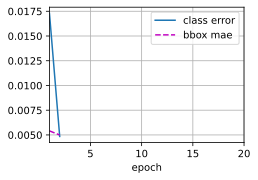

In [ ]:
num_epochs, timer = 20, dl4wm.Timer()
animator = dl4wm.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = dl4wm.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = MultiBoxTarget(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

In [ ]:
# 以下函数已保存在 dl4wm 包中方便以后使用
from collections import namedtuple
Pred_BB_Info = namedtuple("Pred_BB_Info", ["index", "class_id", "confidence", "xyxy"])

def non_max_suppression(bb_info_list, nms_threshold = 0.5):
    """
    非极大抑制处理预测的边界框
    Args:
        bb_info_list: Pred_BB_Info的列表, 包含预测类别、置信度等信息
        nms_threshold: 阈值
    Returns:
        output: Pred_BB_Info的列表, 只保留过滤后的边界框信息
    """
    output = []
    # 先根据置信度从高到低排序
    sorted_bb_info_list = sorted(bb_info_list, key = lambda x: x.confidence, reverse=True)

    while len(sorted_bb_info_list) != 0:
        best = sorted_bb_info_list.pop(0)
        output.append(best)

        if len(sorted_bb_info_list) == 0:
            break

        bb_xyxy = []
        for bb in sorted_bb_info_list:
            bb_xyxy.append(bb.xyxy)

        iou = compute_jaccard(torch.tensor([best.xyxy]), 
                              torch.tensor(bb_xyxy))[0] # shape: (len(sorted_bb_info_list), )

        n = len(sorted_bb_info_list)
        sorted_bb_info_list = [sorted_bb_info_list[i] for i in range(n) if iou[i] <= nms_threshold]
    return output

def MultiBoxDetection(cls_prob, loc_pred, anchor, nms_threshold = 0.5):
    """
    # 按照「9.4.1. 生成多个锚框」所讲的实现, anchor表示成归一化(xmin, ymin, xmax, ymax).
    https://zh.d2l.ai/chapter_computer-vision/anchor.html
    Args:
        cls_prob: 经过softmax后得到的各个锚框的预测概率, shape:(bn, 预测总类别数+1, 锚框个数)
        loc_pred: 预测的各个锚框的偏移量, shape:(bn, 锚框个数*4)
        anchor: MultiBoxPrior输出的默认锚框, shape: (1, 锚框个数, 4)
        nms_threshold: 非极大抑制中的阈值
    Returns:
        所有锚框的信息, shape: (bn, 锚框个数, 6)
        每个锚框信息由[class_id, confidence, xmin, ymin, xmax, ymax]表示
        class_id=-1 表示背景或在非极大值抑制中被移除了
    """
    assert len(cls_prob.shape) == 3 and len(loc_pred.shape) == 2 and len(anchor.shape) == 3
    bn = cls_prob.shape[0]

    def MultiBoxDetection_one(c_p, l_p, anc, nms_threshold = 0.5):
        """
        MultiBoxDetection的辅助函数, 处理batch中的一个
        Args:
            c_p: (预测总类别数+1, 锚框个数)
            l_p: (锚框个数*4, )
            anc: (锚框个数, 4)
            nms_threshold: 非极大抑制中的阈值
        Return:
            output: (锚框个数, 6)
        """
        pred_bb_num = c_p.shape[1]
        anc = (anc + l_p.view(pred_bb_num, 4)).detach().cpu().numpy() # 加上偏移量

        confidence, class_id = torch.max(c_p, 0)
        confidence = confidence.detach().cpu().numpy()
        class_id = class_id.detach().cpu().numpy()

        pred_bb_info = [Pred_BB_Info(
                            index = i,
                            class_id = class_id[i] - 1, # 正类label从0开始
                            confidence = confidence[i],
                            xyxy=[*anc[i]]) # xyxy是个列表
                        for i in range(pred_bb_num)]

        # 正类的index
        obj_bb_idx = [bb.index for bb in non_max_suppression(pred_bb_info, nms_threshold)]

        output = []
        for bb in pred_bb_info:
            output.append([
                (bb.class_id if bb.index in obj_bb_idx else -1.0),
                bb.confidence,
                *bb.xyxy
            ])

        return torch.tensor(output) # shape: (锚框个数, 6)

    batch_output = []
    for b in range(bn):
        batch_output.append(MultiBoxDetection_one(cls_prob[b], loc_pred[b], anchor[0], nms_threshold))

    return torch.stack(batch_output)


### 预测目标

在预测阶段，我们希望能把图像里面所有我们感兴趣的目标检测出来。在下面，我们读取并调整测试图像的大小，然后将其转成卷积层需要的四维格式。

In [ ]:
X = torchvision.io.read_image('Datasets/img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

dl4wm.set_figsize((5, 5))
fig = dl4wm.plt.imshow(img)

使用下面的 `multibox_detection` 函数，我们可以根据锚框及其预测偏移量得到预测边界框。然后，通过非极大值抑制来移除相似的预测边界框。

In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = dl4wm.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

最后，我们筛选所有置信度不低于 0.9 的边界框，做为最终输出。

In [ ]:
def display(img, output, threshold):
    dl4wm.set_figsize((5, 5))
    fig = dl4wm.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        dl4wm.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

### 小结

- 单发多框检测是一种多尺度目标检测模型。基于基础网络块和各个多尺度特征块，单发多框检测生成不同数量和不同大小的锚框，并通过预测这些锚框的类别和偏移量检测不同大小的目标。

- 在训练单发多框检测模型时，损失函数是根据锚框的类别和偏移量的预测及标注值计算得出的。

## 区域卷积神经网络（R-CNN）系列

>(Restart your kernel here)

除了 上节 中描述的单发多框检测之外， 区域卷积神经网络（region-based CNN 或 regions with CNN features，R-CNN）也是将深度模型应用于目标检测的开创性工作之一。 

在本节中，我们将介绍R-CNN及其一系列改进方法：快速的R-CNN（Fast R-CNN）、更快的R-CNN（Faster R-CNN）和掩码R-CNN（Mask R-CNN）。 限于篇幅，我们只着重介绍这些模型的设计思路。

### R-CNN

R-CNN 首先从输入图像中选取若干（例如2000个）提议区域（如锚框也是一种选取方法），并标注它们的类别和边界框（如偏移量）。然后，用卷积神经网络对每个提议区域进行前向计算以抽取其特征。 接下来，我们用每个提议区域的特征来预测类别和边界框。

![](https://i.loli.net/2021/07/11/FMJjeXHLvOKxVfs.png)


上图展示了R-CNN模型。具体来说，R-CNN包括以下四个步骤：

1. 对输入图像使用 选择性搜索 来选取多个高质量的提议区域。这些提议区域通常是在多个尺度下选取的，并具有不同的形状和大小。每个提议区域都将被标注类别和真实边界框。

2. 选择一个预训练的卷积神经网络，并将其在输出层之前截断。将每个提议区域变形为网络需要的输入尺寸，并通过前向计算输出抽取的提议区域特征。

3. 将每个提议区域的特征连同其标注的类别作为一个样本。训练多个支持向量机对目标分类，其中每个支持向量机用来判断样本是否属于某一个类别。

4. 将每个提议区域的特征连同其标注的边界框作为一个样本，训练线性回归模型来预测真实边界框。

尽管 R-CNN 模型通过预训练的卷积神经网络有效地抽取了图像特征，但它的速度很慢。 想象一下，我们可能从一张图像中选出上千个提议区域，这需要上千次的卷积神经网络的前向计算来执行目标检测。 这种庞大的计算量使得 R-CNN 在现实世界中难以被广泛应用。

### Fast R-CNN

R-CNN 的主要性能瓶颈在于，对每个提议区域，卷积神经网络的前向计算是独立的，而没有共享计算。 由于这些区域通常有重叠，独立的特征抽取会导致重复的计算。 Fast R-CNN 对 R-CNN 的主要改进之一，是仅在整张图象上执行卷积神经网络的前向计算。

![image.png](https://i.loli.net/2021/07/11/dCE4ZNeMxqAYvJD.png)

上图中描述了 Fast R-CNN 模型。它的主要计算如下：

1. 与 R-CNN 相比，Fast R-CNN 用来提取特征的卷积神经网络的输入是整个图像，而不是各个提议区域。此外，这个网络通常会参与训练。设输入为一张图像，将卷积神经网络的输出的形状记为  1×𝑐×ℎ1×𝑤1 。

2. 假设选择性搜索生成了 𝑛 个提议区域。这些形状各异的提议区域在卷积神经网络的输出上分别标出了形状各异的兴趣区域。然后，这些感兴趣的区域需要进一步抽取出形状相同的特征（比如指定高度 ℎ2 和宽度 𝑤2 ），以便于连结后输出。为了实现这一目标，Fast R-CNN 引入了 兴趣区域 (RoI) 池化 层：将卷积神经网络的输出和提议区域作为输入，输出连结后的各个提议区域抽取的特征，形状为 𝑛×𝑐×ℎ2×𝑤2 。

3. 通过全连接层将输出形状变换为 𝑛×𝑑 ，其中超参数 𝑑 取决于模型设计。

4. 预测 𝑛 个提议区域中每个区域的类别和边界框。更具体地说，在预测类别和边界框时，将全连接层的输出分别转换为形状为  𝑛×𝑞 （ 𝑞  是类别的数量）的输出和形状为  𝑛×4  的输出。其中预测类别时使用 softmax 回归。

在Fast R-CNN 中提出的兴趣区域池化层与「池化层」节 中介绍的池化层有所不同。在池化层中，我们通过设置池化窗口、填充和步幅的大小来间接控制输出形状。而兴趣区域池化层对每个区域的输出形状是可以直接指定的。

例如，指定每个区域输出的高和宽分别为  ℎ2  和  𝑤2 。 对于任何形状为  ℎ×𝑤  的兴趣区域窗口，该窗口将被划分为  ℎ2×𝑤2  子窗口网格，其中每个子窗口的大小约为 (ℎ/ℎ2)×(𝑤/𝑤2) 。 在实践中，任何子窗口的高度和宽度都应向上取整，其中的最大元素作为该子窗口的输出。 因此，兴趣区域池化层可从形状各异的兴趣区域中均抽取出形状相同的特征。

作为说明性示例， 下图中提到，在 4×4 的输入中，我们选取了左上角  3×3  的兴趣区域。 对于该兴趣区域，我们通过  2×2  的兴趣区域池化层得到一个  2×2  的输出。 请注意，四个划分后的子窗口中分别含有元素 0、1、4、5（5最大）；2、6（6最大）；8、9（9最大）；以及10。

![image.png](https://i.loli.net/2021/07/11/4n9TXWI2tOscoSj.png)


下面，我们演示了兴趣区域池化层的计算方法。 假设卷积神经网络抽取的特征 X 的高度和宽度都是 4，且只有单通道。

In [ ]:
import torch
import torchvision

X = torch.arange(16.).reshape(1, 1, 4, 4)
X

让我们进一步假设输入图像的高度和宽度都是40像素，且选择性搜索在此图像上生成了两个提议区域。 每个区域由5个元素表示：区域目标类别、左上角和右下角的  (𝑥,𝑦)  坐标。

In [ ]:
rois = torch.Tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

由于 X 的高和宽是输入图像高和宽的  1/10 ，因此，两个提议区域的坐标先按 `spatial_scale` 乘以 0.1。 然后，在 X 上分别标出这两个兴趣区域 X[:, :, 1:4, 0:4] 和 X[:, :, 1:4, 0:4] 。 最后，在  2×2  的兴趣区域池化层中，每个兴趣区域被划分为子窗口网格，并进一步抽取相同形状  2×2  的特征。

In [ ]:
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)

### Faster R-CNN

为了较精确地检测目标结果，Fast R-CNN 模型通常需要在选择性搜索中生成大量的提议区域。 Faster R-CNN 提出将选择性搜索替换为 区域提议网络（region proposal network），从而减少提议区域的生成数量，并保证目标检测的精度。

![image.png](https://i.loli.net/2021/07/11/8DHhyC6tiTEPQBd.png)

上图 描述了Faster R-CNN 模型。 与Fast R-CNN 相比，Faster R-CNN 只将生成提议区域的方法从选择性搜索改为了区域提议网络，模型的其余部分保持不变。具体来说，区域提议网络的计算步骤如下：

1. 使用填充为1的  3×3  的卷积层变换卷积神经网络的输出，并将输出通道数记为  𝑐 。这样，卷积神经网络为图像抽取的特征图中的每个单元均得到一个长度为  𝑐  的新特征。

2. 以特征图的每个像素为中心，生成多个不同大小和宽高比的锚框并标注它们。

3. 使用锚框中心单元长度为  𝑐  的特征，分别预测该锚框的二元类别（含目标还是背景）和边界框。

4. 使用非极大值抑制，从预测类别为目标的预测边界框中移除相似的结果。最终输出的预测边界框即是兴趣区域池化层所需的提议区域。

值得一提的是，区域提议网络作为 Faster R-CNN 模型的一部分，是和整个模型一起训练得到的。 换句话说，Faster R-CNN 的目标函数不仅包括目标检测中的类别和边界框预测，还包括区域提议网络中锚框的二元类别和边界框预测。 作为端到端训练的结果，区域提议网络能够学习到如何生成高质量的提议区域，从而在减少了从数据中学习的提议区域的数量的情况下，仍保持目标检测的精度。

### Mask R-CNN

如果在训练集中还标注了每个目标在图像上的像素级位置，那么 Mask R-CNN  能够有效地利用这些详尽的标注信息进一步提升目标检测的精度。

![image.png](https://i.loli.net/2021/07/11/riFJNqdCvhDOUpV.png)

如上图所示，Mask R-CNN 是基于 Faster R-CNN 修改而来的。 具体来说，Mask R-CNN 将兴趣区域池化层替换为了 兴趣区域 (RoI) 对齐 层，使用 双线性插值（bilinear interpolation）来保留特征图上的空间信息，从而更适于像素级预测。 兴趣区域对齐层的输出包含了所有与兴趣区域的形状相同的特征图。 它们不仅被用于预测每个兴趣区域的类别和边界框，还通过额外的全卷积网络预测目标的像素级位置。 本章的后续章节将更详细地介绍如何使用全卷积网络预测图像中像素级的语义。

### 小结

- R-CNN 对图像选取若干提议区域，使用卷积神经网络对每个提议区域执行前向计算以抽取其特征，然后再用这些特征来预测提议区域的类别和边界框。

- Fast R-CNN 对 R-CNN 的一个主要改进：只对整个图像做卷积神经网络的前向计算。它还引入了兴趣区域池化层，从而为具有不同形状的兴趣区域抽取相同形状的特征。

- Faster R-CNN 将 Fast R-CNN 中使用的选择性搜索替换为参与训练的区域提议网络，这样后者可以在减少提议区域数量的情况下仍保证目标检测的精度。

- Mask R-CNN 在 Faster R-CNN 的基础上引入了一个全卷积网络，从而借助目标的像素级位置进一步提升目标检测的精度。